**Mini-Projeto(Reconhecimento de Dígitos)**

Grupo: João Paulo do Nascimento Borges e Jose Messias Marinho Olimpio

O reconhecimento de dígitos escritos a mão é um problema clássico de classificação na área de visão computacional. O problema consiste em receber uma imagem de um número escrito a mão, codificada em tons de cinza, e classificar o dígito decimal (0-9) ali contido. Para estudantes e pesquisadores das técnicas de aprendizado de máquina, o dataset MNIST, cujos exemplos de instâncias estão ilustrados na Figura 1, é utilizado para comparação de técnicas, competições e construções de novas soluções.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
test_filename = 'test.csv'
train_filename = 'train.csv'
test_df = pd.read_csv(test_filename)
train_df = pd.read_csv(train_filename)

# Remove the first column
np_train_df = train_df.to_numpy()[:, 1:]
np_test_df = test_df.to_numpy()[:, 1:]

# CONSTRAINTS
DIGIT = 0
FIRST_PIXEL = 1

### Modelos de Aprendizagem

**PERCEPTRON**

In [4]:
class Perceptron():
  def __init__(self, learning_rate, dimension):
    self.learning_rate = learning_rate
    self.weights = 2*np.random.random(size=dimension) - 1
    self.bias = 2*np.random.random() - 1

  def fit(self, X, y):
    for step in range(1000):
      cost = 0

      for i in range(len(X)):
        y_pred = np.dot(X[i], self.weights) + self.bias
        y_pred = np.where(y_pred > 0, 1, 0)
        error = y[i] - y_pred
        self.weights += self.learning_rate * (error * X[i])
        self.bias += self.learning_rate * error
        cost += error**2
      
      if step % 100 == 0:
        print(f'PLA - Cost at step {step}: {cost}')

  def predict(self, X):
    y_pred = np.dot(X, self.weights) + self.bias
    y_pred = np.where(y_pred > 0, 1, 0)
    return y_pred

**LINEAR REGRESSION**

In [14]:
class LinearRegression:
  def fit(self, _X, _y):
    xT = np.transpose(_X)
    xTx = np.linalg.inv(np.dot(xT, _X))
    pseudo_inverse = np.dot(xTx, xT) 
    self.w = np.dot(pseudo_inverse, _y)
     
  def predict(self, _x):
    wT = np.transpose(self.w)
    return [ np.dot(wT, x_n) for x_n in _x ]

  def getW(self):
    return self.w

**LOGISTIC REGRESSION**

In [20]:
class LogisticRegression:
  def __init__(self, eta=0.1, tmax=2, bs=1000000):
    self.eta = eta
    self.tmax = tmax
    self.batch_size = bs

  def fit(self, _X, _y, epsilon=0.0001):
    X = np.array(_X)
    y = np.array(_y)

    N = X.shape[0]
    d = X.shape[1]
    w = np.zeros(d)

    self.w = []

    for t in range(self.tmax):
      values_sum = 0.0

      for n in range(N):
        yN_wT = y[n] * np.transpose(w)
        values_sum += y[n] * X[n] /( 1 + np.exp(np.inner(yN_wT, X[n])) )

      gT = - ( values_sum / N )

      if(np.linalg.norm(gT) < epsilon): break

      w = w - (self.eta * gT)

    self.w = w    
    
  # funcao hipotese inferida pela regressa logistica  
  def predict_prob(self, X):
    return [ 1 / (1 - np.exp(-(self.__hypothesis_function(x)))) for x in X]

  # Predicao por classificação linear
  def predict(self, X):
    return [ 1 if(1 - np.exp(-(self.__hypothesis_function(x))) >= 0.5) else -1 for x in X]

  def getW(self):
    return self.w

  def getRegressionY(self, regressionX, shift=0):
    return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]

  # Private Methods

  def __hypothesis_function(self, x):
    return np.dot(np.transpose(self.w), x) 

### Funções utilitárias

In [6]:
def pos_pixel(size, i ,j):
  return i*size + j

def symmetry(image):
  size = 28
  sv = 0
  sh = 0
  
  for i in range(size):
    for j in range(int(size/2)):
      p1 = image[pos_pixel(size, i, j)]
      p2 = image[pos_pixel(size, i, (size-1)-j)]
      sv += abs(p1 - p2)
            
      p1 = image[pos_pixel(size, j, i)]
      p2 = image[pos_pixel(size, (size-1)-j, i)]
      sh += abs(p1 - p2)

  sv = sv/255
  sh = sh/255

  s = sv + sh
  
  return s
  
def intensity(image):
  return (np.sum(image)/255.0)


def get_numbers_1_and_5(df):
  filtered_data = []

  for item in df:
    if(item[0] == 1 or item[0] == 5):
      filtered_data.append(item.tolist())

  return filtered_data
  

In [7]:
def plot_linear_classifier(x, y, w, b):
  x1_min, x1_max = x[:,0].min(), x[:,0].max()
  x2_min, x2_max = x[:,1].min(), x[:,1].max()

  x1, x2 = np.meshgrid(np.linspace(x1_min-1, x1_max+1,100), np.linspace(x2_min-1, x2_max+1, 100))
  x_mesh = np.array([x1.ravel(), x2.ravel()]).T

  plt.scatter(x[:,0], x[:,1], c=y.ravel(), cmap='bwr')

  y_mesh = np.dot(x_mesh, np.array(w).reshape(1, -1).T) + b
  y_mesh = np.where(y_mesh <= 0, 0, 1)

  plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap='bwr', alpha=0.5)
  plt.xlim(x1_min-1, x1_max+1)
  plt.ylim(x2_min-1, x2_max+1)

### Classificação dos números 1 e 5

Dados de treinamento

In [8]:
new_train_df = []
images = get_numbers_1_and_5(np_train_df)

for image in images:
  symmetry_ = symmetry(image[FIRST_PIXEL:])
  intensity_ = intensity(image[FIRST_PIXEL:])

  label = 1 if image[DIGIT] == 1 else 0

  new_train_df.append([label, intensity_, symmetry_])

new_train_df = np.array(new_train_df, dtype=int)

Dados de teste

In [12]:
new_test_df = []
images = get_numbers_1_and_5(np_test_df)

for image in images:
  symmetry_ = symmetry(image[FIRST_PIXEL:])
  intensity_ = intensity(image[FIRST_PIXEL:])

  label = 1 if image[DIGIT] == 1 else 0

  new_test_df.append([label, intensity_, symmetry_,])

new_test_df = np.array(new_test_df)

In [9]:
# PERCEPTRON

pla = Perceptron(0.0001, 2)
pla.fit(new_train_df[:, 1:], new_train_df[:, 0])


PLA - Cost at step 0: 2402
PLA - Cost at step 100: 1569
PLA - Cost at step 200: 1440
PLA - Cost at step 300: 1437
PLA - Cost at step 400: 1393
PLA - Cost at step 500: 1365
PLA - Cost at step 600: 1354
PLA - Cost at step 700: 1380
PLA - Cost at step 800: 1379
PLA - Cost at step 900: 1360


NameError: name 'new_test_df' is not defined

In [15]:
# LINEAR REGRESSION

lr = LinearRegression()
X = np.array([ [1, *item] for item in new_train_df[:, 1:] ])
print(new_train_df)
lr.fit(X, new_train_df[:, 0])

[[  1  65 110]
 [  1  52  16]
 [  1  48  46]
 ...
 [  0 121 116]
 [  1  84  60]
 [  1  52  49]]


In [21]:
# LOGISTIC REGRESSION

log_r = LogisticRegression()
X = np.array([ [1, *item] for item in new_train_df[:, 1:] ])
log_r.fit(X, new_train_df[:, 0])

### Gráficos

**PERCEPTRON**

In [64]:
# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

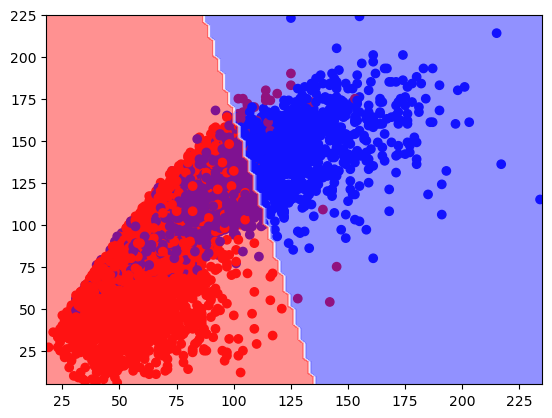

In [10]:
plot_linear_classifier(new_train_df[:, 1:], new_train_df[:, 0], pla.weights, pla.bias)

**Matriz  de confusão**

In [18]:
confusion_matrix(new_test_df[:, 0], lr.predict(new_test_df[:, 1:]))

[[ 216 1108]
 [   7 1521]]


In [13]:
print(classification_report(new_test_df[:, 0], pla.predict(new_test_df[:, 1:])))

              precision    recall  f1-score   support

         0.0       0.96      0.40      0.56      1324
         1.0       0.65      0.99      0.79      1528

    accuracy                           0.71      2852
   macro avg       0.81      0.69      0.68      2852
weighted avg       0.80      0.71      0.68      2852



**REGRESSÃO LINEAR**

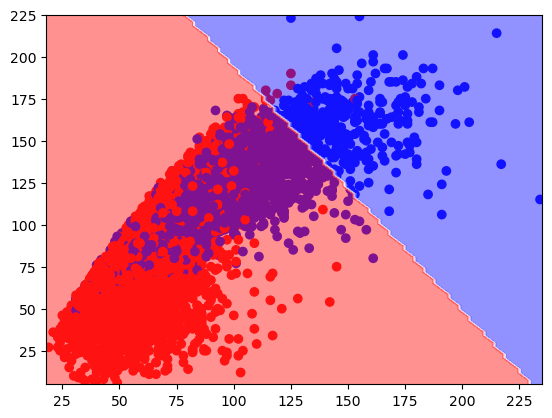

In [16]:
plot_linear_classifier(new_train_df[:, 1:], new_train_df[:, 0], lr.getW()[1:], lr.getW()[0])

**Matriz de confusão**

In [18]:
X = np.array([ [1, *item] for item in new_test_df[:, 1:] ])

y_pred = np.sign(lr.predict(X))
y_pred = np.where(y_pred > 0, 1, 0)

print(confusion_matrix(new_test_df[:, 0], y_pred))

[[ 216 1108]
 [   7 1521]]


In [19]:
print(classification_report(new_test_df[:, 0], y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.16      0.28      1324
         1.0       0.58      1.00      0.73      1528

    accuracy                           0.61      2852
   macro avg       0.77      0.58      0.51      2852
weighted avg       0.76      0.61      0.52      2852



**REGRESSÃO LOGÍSTICA**

In [65]:
log_r.getW()

array([ 0.        , -0.0324043 , -0.03179721])

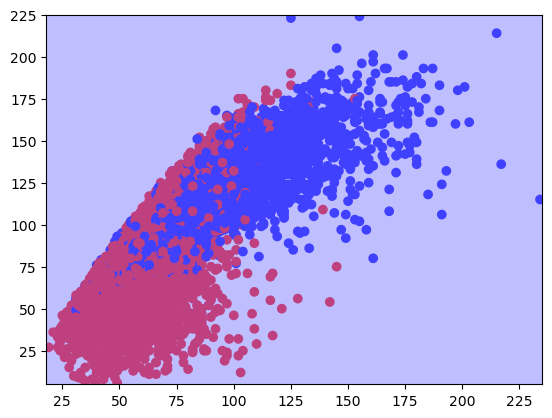

In [22]:
plot_linear_classifier(new_train_df[:, 1:], new_train_df[:, 0], log_r.getW()[1:], log_r.getW()[0])

**Matriz  de confusão**

In [23]:
ones = np.ones((new_test_df.shape[0],1))
X = np.hstack((ones, new_test_df[:, 1:]))

In [24]:
print(confusion_matrix(new_test_df[:, 0], log_r.predict(X)))

[[   0 1324]
 [   0 1528]]


In [25]:
print(classification_report(new_test_df[:, 0], log_r.predict(X)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1324
         1.0       0.54      1.00      0.70      1528

    accuracy                           0.54      2852
   macro avg       0.27      0.50      0.35      2852
weighted avg       0.29      0.54      0.37      2852



/home/messias/miniconda3/envs/ufpb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/messias/miniconda3/envs/ufpb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/messias/miniconda3/envs/ufpb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Classificação de todos os dígitos

Dados de treinamento

In [62]:
new_train_df = []

for image in np_train_df:
  symmetry_ = symmetry(image[FIRST_PIXEL:])
  intensity_ = intensity(image[FIRST_PIXEL:])

  new_train_df.append([image[DIGIT], symmetry_, intensity_])

new_train_df = np.array(new_train_df)

Dados de teste

In [63]:
new_test_df = []

for image in np_test_df:
  symmetry_ = symmetry(image[FIRST_PIXEL:])
  intensity_ = intensity(image[FIRST_PIXEL:])

  new_test_df.append([image[DIGIT], symmetry_, intensity_])

new_test_df = np.array(new_test_df)